# Projet : Anticipez les besoins en consommation électrique de bâtiments    

##  Modèles de prévision pour EnergySiteUse

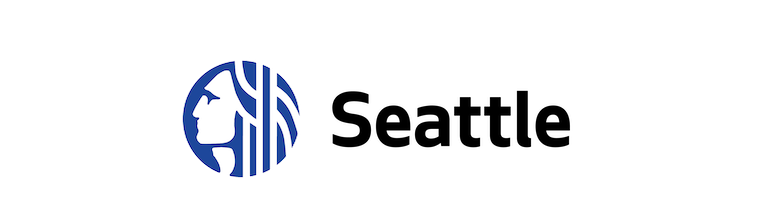

In [573]:
from IPython.display import Image
Image(filename = "images/seattle.png", width=900, height=900)

## Introduction

Notre objectif est de concevoir des modèles de prévision afin de prevoir la consamation énergétique ainsi que les émissions de CO2. Nous allons dans un premier temps effectuer les étapes nécessaires à la mise en place d'un entrainement supervisé et expliquer la méthode d'évaluation des modèles.  
Nous évalurons les modèles avec et sans l'"ENERGYSTRARScore" pour mettre en évidence sa capacité à améliorer les prévisions.

### Table des matières 

* [Mise en place de l'entrainement supervisé](#chapter1)
    * [Prepartion et visualisation des données](#section_1_1)
    * [Pocessus d'évaluation](#section_1_2)
        * [Evaluer l'erreur](#section_1_2_1)
        * [La validation croisée](#section_1_2_2)
        * [Rechercher les paramètres optimaux](#section_1_2_3)
 
* [Modèles de prévision](#chapter2)
    * [Linéaires](#section_2_1)
    * [K neibourgs](#section_2_2)
    * [Arbres de décision](#section_2_3)
    * [SVM](#section_2_4)
    * [BAGGING](#section_2_5)
        * [Random forest](#section_2_5_2)
        * [Extra Trees](#section_2_5_3)
    * [BOOSTING](#section_2_6)
        * [AdaBoost](#section_2_6_1)
        * [Stochastic Gradient](#section_2_6_2)
        * [XGboost ?](#section_2_6_3)
    * [Deep Learning](#section_2_7)
    
* [Conclusion](#chapter3)
    * [Récapitulatif des scores](#section_3_1)
    * [Visualisation du meilleur modèle](#section_3_2)
     


## Chapitre 1 Mise en place de l'entrainement supervisé <a class="anchor" id="chapter1"></a>

### Prepartion et visualisation des données <a class="anchor" id="section_1_1"></a>

Nous importons notre data set qui provient de notre courte analyse exploratoire. Avant toute chose nous devons nous assurer de la distributions normale des données afin d'effectuer des prévisions. Pour cela nous standardisons les variables et passons au log  'SiteEnergyUse(kBtu)' car elle prend de fortes valeurs.

##### Un petit nétoyage 

- Nous supprimons les lignes avec un site "SiteEnergyUse(kBtu)' inferieur ou égal à 0 
- Nous supprimons les batiments avec plus un seul Building, il n'y a en effet que 39 sites avec plus d'un building. Cela ne change rien à l'utilité potentielle de notre modèle dans les cas où l'on veut prévoir la consomation dans ces cas. Il suffira simplement de faire des prévions par building et non pour l'ensemble du site.

In [574]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [575]:
data = pd.read_csv('data_final_last.csv')
data = data.drop(['Unnamed: 0'], axis = 1)
#on mélange le data set au cas où les buiding serait triés d'une quelconque manière 
data = data.sample(frac=1).reset_index(drop=True)
# un petit nétoyage
data = data[data['SiteEnergyUse(kBtu)']>0]
data = data[data['NumberofBuildings'] == 1] # que 39 buidings sinon
data = data.drop(['NumberofBuildings'], axis=1)
data = data[data >= 0]
data

,BuildingType,PrimaryPropertyType,Neighborhood,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,YearBuilt,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),NaturalGas(therms),TotalGHGEmissions
0,0,11,9,10,4,5,1952.0,3.0,0.0,103000.0,103000.0,0.0,0.0,41.0,4.859419e+06,0.0,1.0,147.230
1,1,0,5,0,0,1,1924.0,2.0,0.0,179161.0,117476.0,37321.0,25543.0,NaN,9.705389e+06,0.0,1.0,97.690
2,0,8,3,5,1,4,1989.0,2.0,0.0,23472.0,20695.0,1065.0,945.0,NaN,1.342147e+06,0.0,1.0,31.315
3,0,6,3,6,1,4,1916.0,2.0,0.0,25920.0,11888.0,4329.0,4029.0,NaN,1.312795e+06,0.0,0.0,9.155
4,0,7,2,8,4,5,2005.0,1.0,0.0,26208.0,32427.0,0.0,0.0,79.5,1.532462e+06,0.0,1.0,33.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1649,0,11,3,10,4,5,1968.0,3.0,34510.0,40548.0,75058.0,0.0,0.0,16.0,6.733488e+06,0.0,1.0,304.850
1650,0,8,3,5,4,5,1910.0,5.0,0.0,32250.0,32250.0,0.0,0.0,91.5,7.920347e+05,0.0,1.0,11.425
1651,0,8,7,5,4,5,1980.0,3.0,0.0,34106.0,32739.0,0.0,0.0,46.0,1.846665e+06,0.0,0.0,12.875
1652,0,3,5,5,2,5,2014.0,7.0,73343.5,255896.0,191333.0,133432.0,0.0,100.0,3.861406e+06,0.0,1.0,38.820


In [577]:
data['SiteEnergyUse(kBtu)'].min()

55267.099610000005

In [578]:
data['SiteEnergyUse(kBtu)'].max() 55267.09 279774688.0

279774688.0

In [544]:
data['NumberofFloors'].describe()

count    1562.000000
mean        4.182458
std         6.718224
min         0.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        99.000000
Name: NumberofFloors, dtype: float64

In [545]:
col_Scaler = ['YearBuilt',
              'PropertyGFAParking',
              'PropertyGFABuilding(s)',
              'LargestPropertyUseTypeGFA',
              'SecondLargestPropertyUseTypeGFA',
              'ThirdLargestPropertyUseTypeGFA',
              'ENERGYSTARScore',
             ]
    
data[col_Scaler] = StandardScaler().fit_transform(data[col_Scaler])
data['SiteEnergyUse(kBtu)'] = np.log1p(data['SiteEnergyUse(kBtu)'])
data['TotalGHGEmissions'] = np.log1p(data['TotalGHGEmissions'])
data = data.dropna()

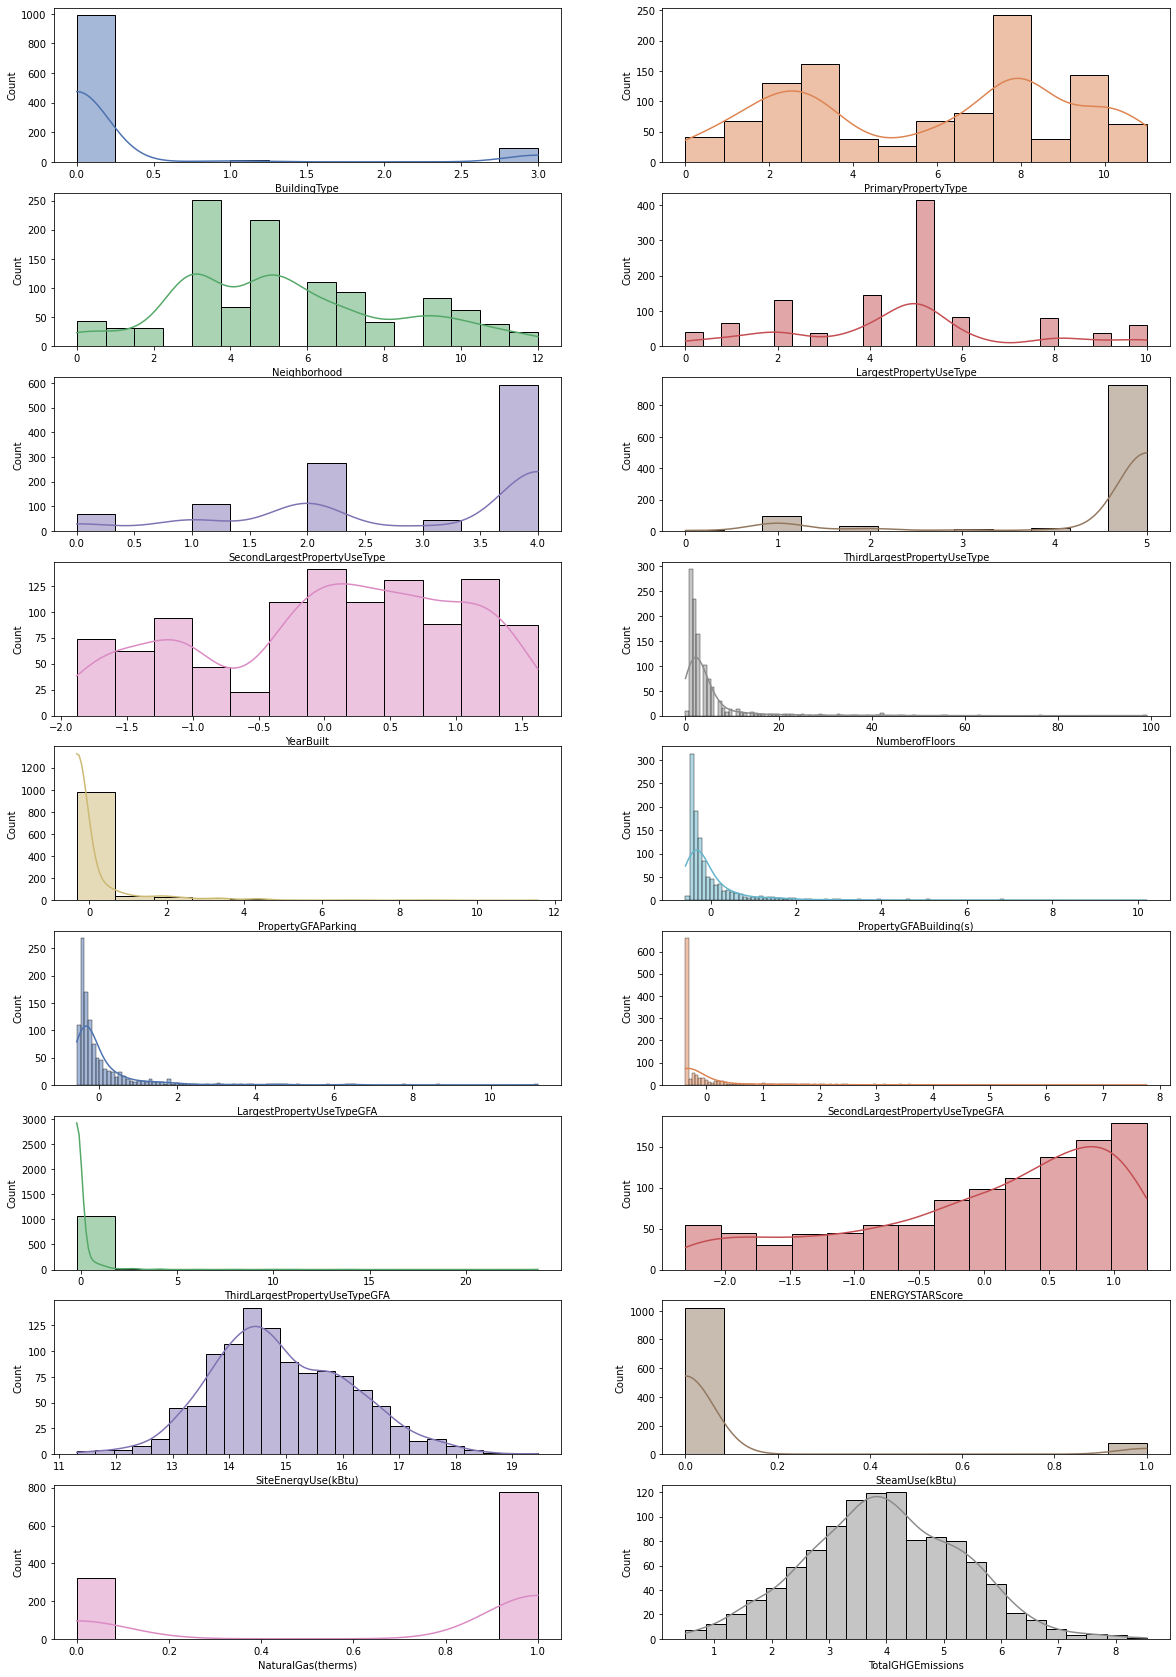

In [546]:
fig, axs = plt.subplots(9, 2, figsize=(20, 30))
i=0
for col in data.columns:
    c = sns.color_palette("deep")[i%10]
    sns.histplot(data=data, x=col, kde=True, color=c, ax=axs[i//2, i%2])
    i = i + 1
plt.show()

In [547]:
col_feature = []
for col in data.columns:
    if (col != 'SiteEnergyUse(kBtu)') and (col != 'TotalGHGEmissions'):
        col_feature.append(col)

X_star = data[col_feature]
X = X_star.drop(columns=["ENERGYSTARScore"])

y_ene = data['SiteEnergyUse(kBtu)']
y_ghe =  data['TotalGHGEmissions']

### Pocessus d'évaluation <a class="anchor" id="section_1_2"></a>

#### Evaluer l'erreur  <a class="anchor" id="section_1_2_1"></a>

Il nous faut définir une métrique pour évaluer l'erreur :   
Nous allons avoir un vecteur de valeurs qui comporte des prédictions que nous allons comparé avec les valeurs attendues. La métrique choisie sera la mean square error definie par   
$$
M S E=\frac{1}{n} \sum_{i=1}^{n}\left(f\left(x_{i}\right)-y_{i}\right)^{2}
$$  

Nous relèverons également le coefficient de détermination $R^{2}$ qui indique à quel point les valeurs prédites sont corrélées aux vraies valeurs.  

$$
R=\frac{\sum_{i=1}^{n}\left(y_{i}-\bar{y}\right)\left(f\left(x_{i}\right)-\overline{f(x)}\right)}{\sqrt{\sum_{i=1}^{n}\left(y_{i}-\bar{y}\right)^{2}} \sqrt{\sum_{i=1}^{n}\left(f\left(x_{i}\right)-\overline{f(x)}\right)^{2}}}
$$

- Une fois le meilleur modèle et les meilleurs paramètres identifiés, nous nous effecturons le calcul de la MAPE à partir des prédictions inversées (pour avoir une estimation de la précision réelle en %) 
$$
\mathrm{MAPE}=\frac{100 \%}{n} \sum_{t=1}^{n}\left|\frac{A_{t}-F_{t}}{A_{t}}\right|
$$

#### La validation croisée <a class="anchor" id="section_1_2_2"></a>

Pour obtenir un resultat de précision sur l'ensemble du jeu de données nous allons opérer une validation croisée dotée de 5 fold. Le pocessus est le suivant : 
- Il faut "découper" notre data set en 5 parties (folds)
- Entrainer le modèles sur 4 parties et evaluer la performance sur celle restante. 
- Enfin on fait la moyenne des scores obtenus pour calculer la performance globale.

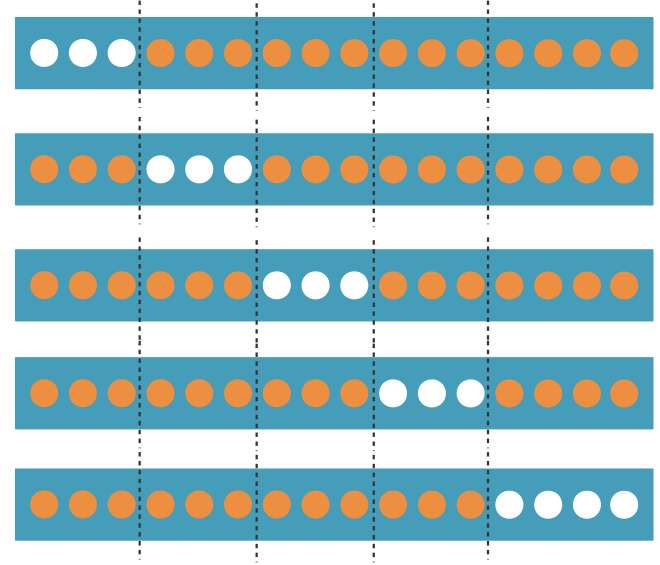

In [548]:
from IPython.display import Image
Image(filename = "images/CV.png", width=400, height=400)

#### Rechercher les paramètres optimaux <a class="anchor" id="section_1_2_3"></a>

Pour un modèle donné nous avons un large de choix de paramètres possibles. Il existe des outils pour identifier ceux qui donnent les meilleurs résultats :   

- **GridSearchCV** : evaluation du modèle sur l'ensemble de la grille des paramètres
- **RandomSearchCV** : evaluation du modèle avec des paramètres aléatoires la grille des paramètres
- **Hyperopt** : evalution du modèle avec optimisation successive de chaque paramètre.

Nous allons utiliser **GridSearchCV** pour l'ensemble des modèles, à l'exception des réseaux de neurones ou nous utiliserons **Hyperopt**.

## Chapitre 2 Modèles de prévision <a class="anchor" id="chapter2"></a>

Dans cette section nous allons implémenter divers modèles d'appentissage supervisé. Nous donnerons une courte définition des modèles ainsi que des paramètres à optimiser. Pour chaque modèle nous allons opérer 4 recherches de paramètre selon les targets : 
- **SiteEnergyUse(kBtu)** sans **l'EnergyStarSCORE**
- **SiteEnergyUse(kBtu)** avec **l'EnergyStarSCORE**
- **TotalGHGEmissions** sans **l'EnergyStarSCORE**
- **TotalGHGEmissions** avec **l'EnergyStarSCORE**

In [549]:
from sklearn import linear_model
import numpy as np
# importations des librairies
import math
import numpy as np
import pandas as pd
import time
#import modin.pandas as pd
import matplotlib.pyplot as plt
#plt.style.use('ggplot')
import seaborn as sns
from scipy import stats
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV, MultiTaskLassoCV, MultiTaskElasticNetCV
from sklearn.model_selection import GridSearchCV
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score, mean_squared_error
from sklearn.utils.fixes import parse_version
from sklearn.preprocessing import QuantileTransformer, quantile_transform
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, RobustScaler
from sklearn import set_config

### Création d'une base line

Nous allons créer un modèle simple de régression linéaire qui va constituer notre base line. Notre objectif sera alors de faire mieux en utilisant des modèles plus évolués.

### Linéaires <a class="anchor" id="section_2_1"></a>

In [550]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
num_folds = 5
def ml_baseline(X,y) :
    num_folds = 5
    seed = 7
    scoring = {
        'r2': 'r2',
        'nmse': 'neg_mean_squared_error'
    }

    model = LinearRegression()
    kfold = KFold(n_splits=num_folds)
    results = cross_validate(model, X, y, cv=kfold, scoring=scoring)
    #print(results)#['test_nmse'].mean)
    return results
    #for mean, stdev, param in zip(means, stds, params):
        #print("%f (%f) with: %r" % (mean, stdev, param))

In [491]:
print(" ________ SiteEnergyUse(kBtu) _______")
print("nmse :")
print(ml_baseline(X, y_ene)['test_nmse'].mean())
print("r2 :")
print(ml_baseline(X, y_ene)['test_r2'].mean())

print("    Avec EnergyStarSCORE :")
print("nmse :")
print( ml_baseline(X_star, y_ene)['test_nmse'].mean())
print("r2 :")
print( ml_baseline(X_star, y_ene)['test_r2'].mean())

print("  ")
print(" _______ TotalGHGEmissions _______ ")
print("nmse :")
print( ml_baseline(X, y_ghe)['test_nmse'].mean())
print("r2 :")
print(ml_baseline(X, y_ghe)['test_r2'].mean())

print("    Avec EnergyStarSCORE :")
print("nmse :")
print( ml_baseline(X_star, y_ghe)['test_nmse'].mean())
print("r2 :")
print( ml_baseline(X_star, y_ghe)['test_r2'].mean())


 ________ SiteEnergyUse(kBtu) _______
nmse :
-0.6782571763410007
r2 :
0.5412037506313514
    Avec EnergyStarSCORE :
nmse :
-0.5812835136337522
r2 :
0.6067438384423489
  
 _______ TotalGHGEmissions _______ 
nmse :
-0.8131299600767964
r2 :
0.54301301878182
    Avec EnergyStarSCORE :
nmse :
-0.7198186620543396
r2 :
0.5956394182960424


### K neibourgs  <a class="anchor" id="section_2_2"></a>

Nous utilisons ensuite le modèle des plus proches voisins. Ce modèle constiste à estimer la valeurs à prédire en faisant une moyenne des points les plus "proches" dans l'espace des features. 

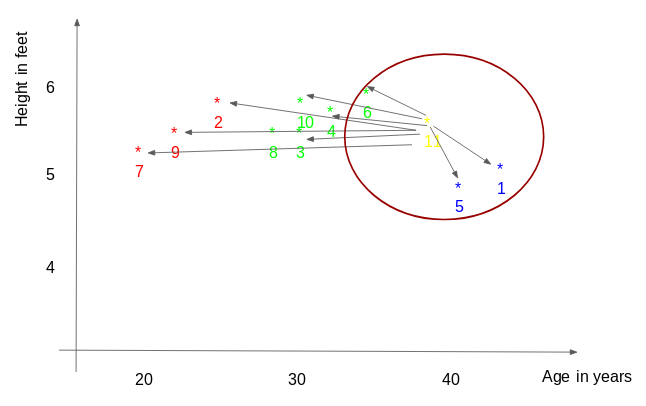

In [492]:
from IPython.display import Image
Image(filename = "images/knn.png", width=500, height=500)

Nous allons chercher à optimiser les paramètres suivants :  
- n_neighbors : le nombre de voisins les plus proches à utiliser
- weights : Pour effectuer la moyenne nous avons plusieurs possibilités, ici soit nous utilisons des poids uniformes, soit des poids inversement proportionnels à la distance de notre point.
- metric : Pour caluer les distances de notre point à un autre plusieurs "normes" existent, ici nous selectionnons les deux suivantes :
    - euclidean : $\sqrt{\sum_{i=1}^{k}\left(x_{i}-y_{i}\right)^{2}}$
    - manhattan : ${\sum_{i=1}^{k}\left(x_{i}-y_{i}\right)}$

In [518]:
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
def ml_k_neibourg(X,y) :
    num_folds = 5
    seed = 7
    scoring = 'neg_mean_squared_error'# Grid search cv
    scoring = {
        'r2': 'r2',
        'nmse': 'neg_mean_squared_error'
    }

    param_grid = {'n_neighbors':[1, 3,5,11,19,30],
                'weights' : ['uniform','distance'],
                'metric' : ['euclidean','manhattan']
    }


    model = KNeighborsRegressor()
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold, refit = 'nmse')
    grid_result = grid.fit(X, y)
    rank = np.argmin(grid_result.cv_results_['rank_test_nmse'])
    mean_r2 = grid_result.cv_results_['mean_test_r2'][rank]
    print("Best: %f avec %s, r2 : %f" % (grid_result.best_score_, grid_result.best_params_, mean_r2))
    means = grid_result.cv_results_['mean_test_nmse']
    stds = grid_result.cv_results_['std_test_nmse']
    params = grid_result.cv_results_['params']
    #for mean, stdev, param in zip(means, stds, params):
        #print("%f (%f) with: %r" % (mean, stdev, param))
    

In [519]:
print(" ------------ SiteEnergyUse(kBtu) ----------- ")
ml_k_neibourg(X, y_ene)
print("      *Avec EnergyStarSCORE* ")
ml_k_neibourg(X_star, y_ene)
print("  ")
print(" ------------ TotalGHGEmissions ----------- ")
ml_k_neibourg(X, y_ghe)
print("      *Avec EnergyStarSCORE* ")
ml_k_neibourg(X_star, y_ghe)

 ------------ SiteEnergyUse(kBtu) ----------- 
Best: -0.545177 avec {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}, r2 : 0.627742
      *Avec EnergyStarSCORE* 
Best: -0.455479 avec {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}, r2 : 0.689007
  
 ------------ TotalGHGEmissions ----------- 
Best: -0.831860 avec {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}, r2 : 0.532503
      *Avec EnergyStarSCORE* 
Best: -0.764202 avec {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}, r2 : 0.568979


### Arbres de décision  <a class="anchor" id="section_2_3"></a>

Les arbres de décision sont des modèles prédictifs qui utilisent un ensemble de règles binaires pour calculer une valeur à prédire. Ils se composent de branches, noeuds de décision et de feuilles.

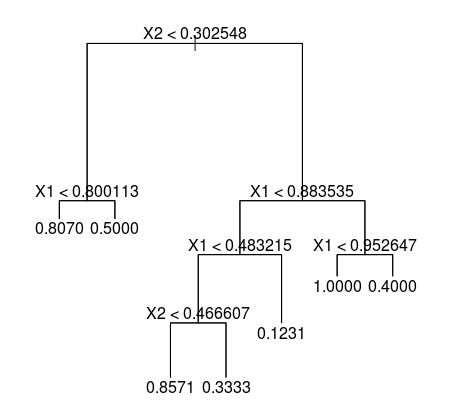

In [68]:
Image(filename = "images/arbre.png", width=500, height=500)

Les paramètres que nous décidons d'optimiser sont les suivants : 
- max_depth : La hauteur (ou profondeure) maximale que l'arbre peut atteindre
- min_samples_split : taille minimale de l'échantillon pour créer un nouveau noeud
- max_leaf_node : Le nombre maximal de noeds externes donnant lieu à des feuilles 

In [520]:
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor

def ml_tree(X,y):
    num_folds = 5
    seed = 7
    scoring = 'neg_mean_squared_error'# Grid search cv
    scoring = {
        'r2': 'r2',
        'nmsle': 'neg_mean_squared_log_error',
        'nmse': 'neg_mean_squared_error'
    }

    param_grid = {
                  "min_samples_split": [10, 20, 40],
                  "max_depth": [2, 6, 8, 10, 15],
                  "max_leaf_nodes": [ 30, 50, 60, 70],
                  }

    model = DecisionTreeRegressor()
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold, refit = 'nmse')
    grid_result = grid.fit(X, y)
    rank = np.argmin(grid_result.cv_results_['rank_test_nmse'])
    mean_r2 = grid_result.cv_results_['mean_test_r2'][rank]
    print("Best: %f avec %s, r2 : %f" % (grid_result.best_score_, grid_result.best_params_, mean_r2))
    means = grid_result.cv_results_['mean_test_nmse']
    stds = grid_result.cv_results_['std_test_nmse']
    params = grid_result.cv_results_['params']
    #for mean, stdev, param in zip(means, stds, params):
        #print("%f (%f) with: %r" % (mean, stdev, param))

    #print()

In [521]:
print(" ------------ SiteEnergyUse(kBtu) ----------- ")
ml_tree(X, y_ene)
print("      *Avec EnergyStarSCORE* ")
ml_tree(X_star, y_ene)
print("  ")
print(" ------------ TotalGHGEmissions ----------- ")
ml_tree(X, y_ghe)
print("      *Avec EnergyStarSCORE* ")
ml_tree(X_star, y_ghe)

 ------------ SiteEnergyUse(kBtu) ----------- 
Best: -0.425634 avec {'max_depth': 15, 'max_leaf_nodes': 30, 'min_samples_split': 10}, r2 : 0.711462
      *Avec EnergyStarSCORE* 
Best: -0.383280 avec {'max_depth': 10, 'max_leaf_nodes': 60, 'min_samples_split': 20}, r2 : 0.737718
  
 ------------ TotalGHGEmissions ----------- 
Best: -0.638722 avec {'max_depth': 8, 'max_leaf_nodes': 50, 'min_samples_split': 20}, r2 : 0.639949
      *Avec EnergyStarSCORE* 
Best: -0.643689 avec {'max_depth': 15, 'max_leaf_nodes': 50, 'min_samples_split': 10}, r2 : 0.637386


### SVR  à noyaux <a class="anchor" id="section_2_4"></a>

Premièrement : Les SVR sont des méthodes linéaires, elles consistent à déterminer un tube de rayon epsilon qui minimise la distance entre les points à l'exterieur du tube et ses propres frontières. On utilise ensuite la droite centrale du tube pour evaluer la prédiction.

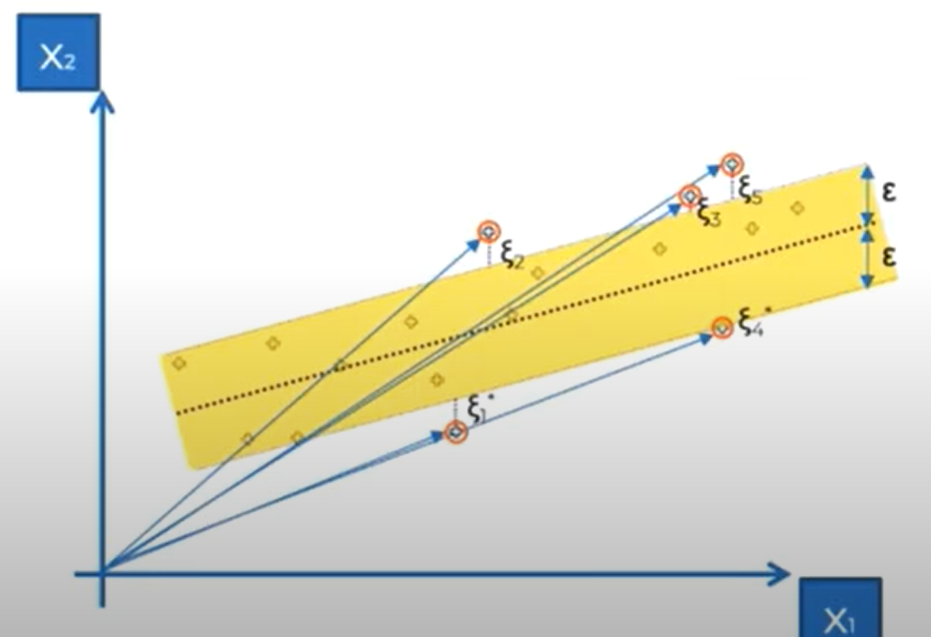

In [522]:
Image(filename = "images/svm.png", width=500, height=500)

Deuxièmement : Les méthodes à noyaux permettent de "convertir" un problème non linéaire en un problème linéaire. L'idée est de plonger les données dans un espace à plus grande dimension pour les 'encadrer' de manière optimale.  
Voici un exemple illustratif dans le cadre d'une classification, on cherche dans ce cas un hyper plan qui va separer nos données.

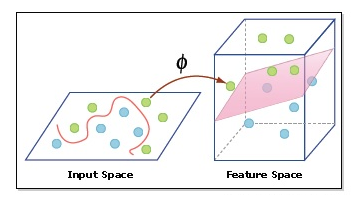

In [523]:
Image(filename = "images/noyaux.png", width=500, height=500)

Les méthodes SVM à noyaux sont donc la combinaison de ces deux méthodes.
Nous allons évaluer les paramètres suivants :  
- Pour la partie SVR :
    - La taille de $\epsilon$ (rayon du tube)
- Pour la partie noyau :
    - Les fonctions de projection (ici noyau gaussien ou alors polynomial)
    

In [524]:
param = {'kernel' : ( 'poly', 'rbf'),'C' : [1,5,10],'degree' : [3,8],'coef0' : [0.01,10,0.5],'gamma' : ('auto','scale')},

In [525]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.svm import SVR
from sklearn.model_selection import KFold

def ml_svm(X,y):
    num_folds = 5
    seed = 7
    scoring = 'neg_mean_squared_error'# Grid search cv
    scoring = {
        'r2': 'r2',
        'nmsle': 'neg_mean_squared_log_error',
        'nmse': 'neg_mean_squared_error'
    }
    grid_params = {'kernel' : ('rbf', 'poly'),
                   'epsilon' : [0.01,0.05,0.1,0.5,1],
                   'degree' : [1,2,3,5]}

    model = SVR()
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    grid = GridSearchCV(estimator=model, param_grid=grid_params, scoring=scoring, cv=kfold, refit = 'nmse')
    grid_result = grid.fit(X, y)
    rank = np.argmin(grid_result.cv_results_['rank_test_nmse'])
    mean_r2 = grid_result.cv_results_['mean_test_r2'][rank]
    print("Best: %f avec %s, r2 : %f" % (grid_result.best_score_, grid_result.best_params_, mean_r2))
    means = grid_result.cv_results_['mean_test_nmse']
    stds = grid_result.cv_results_['std_test_nmse']
    params = grid_result.cv_results_['params']
    #for mean, stdev, param in zip(means, stds, params):
        #print("%f (%f) with: %r" % (mean, stdev, param))

#print()

In [526]:
print(" ------------ SiteEnergyUse(kBtu) ----------- ")
ml_svm(X, y_ene)
print("      *Avec EnergyStarSCORE* ")
ml_svm(X_star, y_ene)
print("  ")
print(" ------------ TotalGHGEmissions ----------- ")
ml_svm(X, y_ghe)
print("      *Avec EnergyStarSCORE* ")
ml_svm(X_star, y_ghe)

 ------------ SiteEnergyUse(kBtu) ----------- 
Best: -0.522581 avec {'degree': 1, 'epsilon': 0.05, 'kernel': 'rbf'}, r2 : 0.645564
      *Avec EnergyStarSCORE* 
Best: -0.392730 avec {'degree': 1, 'epsilon': 0.01, 'kernel': 'rbf'}, r2 : 0.732484
  
 ------------ TotalGHGEmissions ----------- 
Best: -0.765785 avec {'degree': 1, 'epsilon': 0.01, 'kernel': 'rbf'}, r2 : 0.570041
      *Avec EnergyStarSCORE* 
Best: -0.670894 avec {'degree': 1, 'epsilon': 0.01, 'kernel': 'rbf'}, r2 : 0.622322


### Méthodes ensemblistes  <a class="anchor" id="section_2_5"></a>

Les méthodes ensemblistes consistent à combiner plusieurs modèles d'apprenant faibles afin de faire une prédiction. Il existe deux grandes familles :  
- Le Bagging : reduit la variance en combinant les résultats de plusieurs modèles entraînés sur des sous ensembles de données de notre jeu initial en utilisant la méthode de bootstraping. Les modèles sont entraînés sans interaction entre eux.   
.  
- Le Boosting : reduit le biais en entraînant successivement plusieurs modèles. Au fur et à mesure on décide d’augmenter les poids associés aux observations qui induisent le précédent modèle en erreur, afin de leur donner plus d’importance dans l’entraînement.

#### Bagging : Random forest <a class="anchor" id="section_2_5_1"></a>

Nous présentons donc le modèle de foret aléatoire, elle se compose de plusieurs arbres de décisions générés aléatoirement et focalisant chacun sur un nombre limité de features.

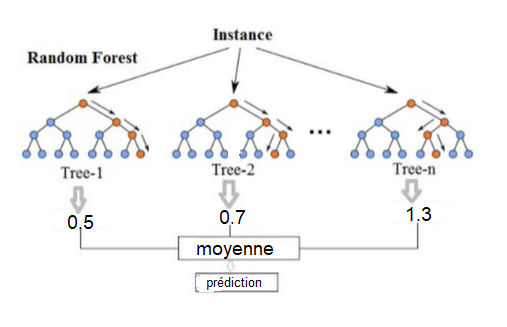

In [78]:
Image(filename = "images/rf.png", width=500, height=500)

les paramètres à optimiser sont donc les mêmes que pour les arbres de décisions, à l'exception qu'il faut ajouté le nombre 
d'arbres maximum à utiliser ainsi que le nombre de feature.

- max_depth : La hauteur (ou profondeure) maximale que l'arbre peut atteindre
- min_samples_split : taille minimale de l'échantillon pour créer un nouveau noeud
- max_leaf_node : Le nombre maximal de noeds externes donnant lieu à des feuilles 
- max_features : Le nombre maximal de features utilisables dans un arbre
- n_estimators : Le nombre d'arbre maximal à utiliser pour notre modèle

In [527]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

def ml_random(X, y):
    num_folds = 5
    seed = 7
    scoring = 'neg_mean_squared_error'# Grid search cv
    scoring = {
        'r2': 'r2',
        'nmsle': 'neg_mean_squared_log_error',
        'nmse': 'neg_mean_squared_error'
    }
    grid_params = {
     'n_estimators' : [10,50,100],
     'max_features' : [2,5,7,10],
     "min_samples_split": [10, 20, 40],
     "max_depth": [1, 2, 3, 4],
     "max_leaf_nodes": [ 30, 50, 60, 70],
     }

    model = RandomForestRegressor(random_state=seed)
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    grid = GridSearchCV(estimator=model, param_grid=grid_params, scoring=scoring, cv=kfold, refit = 'nmse')
    grid_result = grid.fit(X, y)
    rank = np.argmin(grid_result.cv_results_['rank_test_nmse'])
    mean_r2 = grid_result.cv_results_['mean_test_r2'][rank]
    print("Best: %f avec %s, r2 : %f" % (grid_result.best_score_, grid_result.best_params_, mean_r2))
    means = grid_result.cv_results_['mean_test_nmse']
    stds = grid_result.cv_results_['std_test_nmse']
    params = grid_result.cv_results_['params']
    #for mean, stdev, param in zip(means, stds, params):
        #print("%f (%f) with: %r" % (mean, stdev, param))

    #print()

In [528]:
print(" ------------ SiteEnergyUse(kBtu) ----------- ")
ml_random(X, y_ene)
print("      *Avec EnergyStarSCORE* ")
ml_random(X_star, y_ene)
print("  ")
print(" ------------ TotalGHGEmissions ----------- ")
ml_random(X, y_ghe)
print("      *Avec EnergyStarSCORE* ")
ml_random(X_star, y_ghe)

 ------------ SiteEnergyUse(kBtu) ----------- 
Best: -0.405389 avec {'max_depth': 4, 'max_features': 10, 'max_leaf_nodes': 30, 'min_samples_split': 10, 'n_estimators': 100}, r2 : 0.725702
      *Avec EnergyStarSCORE* 
Best: -0.362969 avec {'max_depth': 4, 'max_features': 10, 'max_leaf_nodes': 30, 'min_samples_split': 10, 'n_estimators': 50}, r2 : 0.753603
  
 ------------ TotalGHGEmissions ----------- 
Best: -0.637595 avec {'max_depth': 4, 'max_features': 10, 'max_leaf_nodes': 30, 'min_samples_split': 10, 'n_estimators': 100}, r2 : 0.641473
      *Avec EnergyStarSCORE* 
Best: -0.600158 avec {'max_depth': 4, 'max_features': 10, 'max_leaf_nodes': 30, 'min_samples_split': 10, 'n_estimators': 100}, r2 : 0.662237


In [13]:
rf = RandomForestRegressor()
rf.fit(X, y_ene)
features_importance = pd.DataFrame(rf.feature_importances_,
                                  index = X.columns,
                                  columns = ['importance']).sort_values('importance', ascending = False)
                                  

In [14]:
features_importance

,importance
PropertyGFABuilding(s),0.359202
LargestPropertyUseTypeGFA,0.260384
PrimaryPropertyType,0.124756
LargestPropertyUseType,0.059502
YearBuilt,0.053070
NaturalGas(therms),0.025949
NumberofFloors,0.024039
Neighborhood,0.023051
PropertyGFAParking,0.017842
SecondLargestPropertyUseTypeGFA,0.015515


#### Boosting : AdaBoost <a class="anchor" id="section_2_6_1"></a>

A la différence de la random forest :
- Les arbres sont ici crées les uns après les autres afin de minimiser l'erreur des arbres précédemment crées. 
- Les arbres sont ici des "souches" c'est à dire un arbre avec seulement 2 feuilles. 
- Pour obtenir la prédiction finale on effectue un moyenne pondérée des arbres en fonction de leurs importances dans la forêt. 

Voici un exemple illustratif pour le cas d'une classification, on peut voir que d'un modèle à l'autre (box) l'importance des points (+ et -) à classifier deviennent plus ou moins important durant les créations successives des apprenants faibles :

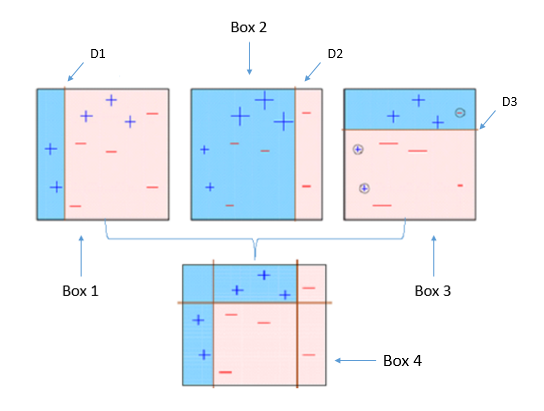

In [86]:
Image(filename = "images/ada.png", width=500, height=500)

Nous allons chercher à optimiser les deux paramètres suivants : 
- n_estimators : le nombre d'apprenants faibles à utiliser
- learning_rate : l'importance apportée du nouveau modèle à celui existant

In [553]:
from sklearn.ensemble import AdaBoostRegressor

def ml_ada(X,y):
    num_folds = 5
    seed = 7
    scoring = 'neg_mean_squared_error'# Grid search cv
    scoring = {
        'r2': 'r2',
        'nmse': 'neg_mean_squared_error'
    }
    param_grid = {
     'n_estimators': [ 500, 700, 1500],
     'learning_rate' : [0.01, 0.05, 0.5, 1],
     }

    model = AdaBoostRegressor(random_state=seed)
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold, refit = 'nmse')
    grid_result = grid.fit(X, y)
    rank = np.argmin(grid_result.cv_results_['rank_test_nmse'])
    mean_r2 = grid_result.cv_results_['mean_test_r2'][rank]
    print("Best: %f avec %s, r2 : %f" % (grid_result.best_score_, grid_result.best_params_, mean_r2))
    means = grid_result.cv_results_['mean_test_nmse']
    stds = grid_result.cv_results_['std_test_nmse']
    params = grid_result.cv_results_['params']
    #for mean, stdev, param in zip(means, stds, params):
        #print("%f (%f) with: %r" % (mean, stdev, param))

    #print()

In [554]:
print(" ------------ SiteEnergyUse(kBtu) ----------- ")
ml_ada(X, y_ene)
print("      *Avec EnergyStarSCORE* ")
ml_ada(X_star, y_ene)
print("  ")
print(" ------------ TotalGHGEmissions ----------- ")
ml_ada(X, y_ghe)
print("      *Avec EnergyStarSCORE* ")
ml_ada(X_star, y_ghe)

 ------------ SiteEnergyUse(kBtu) ----------- 
Best: -0.425049 avec {'learning_rate': 0.05, 'n_estimators': 500}, r2 : 0.711351
      *Avec EnergyStarSCORE* 
Best: -0.316911 avec {'learning_rate': 1, 'n_estimators': 1500}, r2 : 0.784460
  
 ------------ TotalGHGEmissions ----------- 
Best: -0.675246 avec {'learning_rate': 1, 'n_estimators': 500}, r2 : 0.613086
      *Avec EnergyStarSCORE* 
Best: -0.567034 avec {'learning_rate': 1, 'n_estimators': 1500}, r2 : 0.676012


### Réseau de neurones et hyperopt <a class="anchor" id="section_2_7"></a>

Pour finir nous allons évaluer les performance d'un réseau de neurones, les paramètres ainsi que l'architecture optimale du réseau seront identifiés à l'aide du module **hyperopt**.  
A la différence des méthodes GridSearch et RandomSearch, hyperopt utilise un processus d'optimisation Bayésienne. C'est à dire qu'au fur et à mesure des configurations utiliser, on calcule les probabilités de diverses causes hypothétiques (hyper paramètres) à partir de l'observation d'événements connus (le score du modèle).


Le processus d'utilisation de hyperopt est le suivant :
- Définir l'espace de recher des paramètres. Dans la fonction **build_space** on peut voir l'ensemble des paramètres possibles. On peut remarquer que l'architecture du modèle va évolée (nombre de neurones, nombres de couches..) certaines caratéristiques vont restés fixes pour limiter le temps calcul (fonction d'activation, optimizer..)
- Création du modèle avec les paramètres dans la fonction **buil_model**
- Calcul du score par validation croisée dans **deep_hp** et recupération des paramètres utilisés.

Ensuite la fonction **fmin** va minimiser l'erreur en fonction des paramètres possibles, nous mettons seulement 15 essais pour des raisons de temps cpu.

In [432]:
 scoring = {
        'r2': 'r2',
        'nmse': 'neg_mean_squared_error'
    }

def build_space(X,y,cv):
    space = {'choice': hp.choice('num_layers',
                          [ {'layers':'one'},
                            {'layers':'two',
                            'units2' :  scope.int(hp.quniform('units2',5,50,10)),
                            'dropout2' : hp.uniform('dropout2', .15,.3)},
                            {'layers':'three',
                            'units32': scope.int(hp.quniform('units32',5,30,5)), 
                            'units33' : scope.int(hp.quniform('units33',5,30,5)),
                            'dropout32' : hp.uniform('dropout32', .15,.3),
                            'dropout33' : hp.uniform('dropout33', .15,.3)}
                            ]),
                'units1': scope.int(hp.quniform('units',5,100,15)),
                'dropout1': hp.uniform('dropout1', .15,.3),
                'optimizer': 'adam',
                'epoch' : 500,
                #'batch_size' : scope.int(hp.quniform('batch_size',16,500,20)),
                'batch_size' : hp.choice('batch_size',[32, 64, 128]),
                'regularisation' : hp.choice('regularisation',[None, 'l1', 'l2']),
                'activation' : 'relu', #hp.choice('activation',['relu', 'sigmoid']),
                'input_shape' : X.shape[1],
                'X' : X,
                'y' : y,
                'cv' : cv 
            }
    return space

# def de la fonction avec abjectif
def buil_model(space):
    ## recuperation des variables depuis space
    units1 = space['units1']
    dropout1 = space['dropout1']
    optimizer = space['optimizer']
    regularisation = space['regularisation']
    activation = space['activation']
    input_shape = space['input_shape']
    #print('buil_model buil_model buil_model')
    #print(input_shape)
    neurones_interm = []
    dropout_interm = []
    
    if space['choice']['layers'] == 'two':
        neurones_interm = [space['choice']['units2']] 
        dropout_interm = [space['choice']['dropout2']]
    
    if space['choice']['layers'] == 'three':
        neurones_interm = [space['choice']['units32'], space['choice']['units33']] 
        dropout_interm = [space['choice']['dropout32'], space['choice']['dropout33']] 
   
    ## Creation du modèle
    model = Sequential()
    # Première couche input layer
    model.add(Dense(units1, input_dim=input_shape, activation = activation, kernel_regularizer=regularisation))
    model.add(Dropout(rate = dropout1))
    # Couches interms
    for i in range(len(neurones_interm)):
        model.add(Dense(neurones_interm[i], activation = activation, kernel_regularizer=regularisation))
        model.add(Dropout(rate = dropout_interm[i]))
    
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer = 'adam' )
    return model
    

def deep_hp(space):
    epoch = space['epoch']
    batch_size = space['batch_size']
    X = space['X']
    y = space['y']
    cv = space['cv']
    
    def deep_hp_buid():
        return buil_model(space)
    model =deep_hp_buid()# buildmodel(16)#buil_model(space)
    # on impose un EarlyStopping pour eviter le sur apprentissage
    # es = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=20)
    estimator = KerasRegressor(build_fn=deep_hp_buid, epochs=epoch, batch_size=batch_size, verbose=0)
                               #callbacks=[TqdmCallback(verbose=1)],
                               #validation_split=0.1)
    kfold = KFold(n_splits = cv)
    #model.fit(X, y, epochs=epoch,
              #verbose=1, batch_size = batch_size)
    results = cross_validate(estimator, X, y, cv=kfold , scoring=scoring)
    #print(results)
    #print(- results['test_nmse'].mean())
    return {'loss': - results['test_nmse'].mean(),'r2_loss' :  results['test_r2'].mean(),'status': STATUS_OK, 'model': model, 'params': space}
    #return {'loss': - results.mean()}


In [559]:
trials = Trials()
space = build_space(X, y_ene, 5)
best = fmin(deep_hp,
            space,
            algo=tpe.suggest,
            max_evals=20,
            trials=trials)
best_params = trials.results[np.argmin([r['loss'] for r in trials.results])]
print('mse :' + ' ' + str(best_params['loss']))
print('r2 :' + ' ' + str(best_params['r2_loss']))
for name_ in best_params['params'].keys():
    if name_ != 'X' and name_ != 'y':
        print(name_ +':'+' '+ str(best_params['params'][name_]))

100%|████████████████████████████████████████████████| 20/20 [32:12<00:00, 96.62s/trial, best loss: 0.5445443914107873]
mse : 0.5445443914107873
r2 : 0.6335629637829436
activation: relu
batch_size: 32
choice: {'layers': 'one'}
cv: 5
dropout1: 0.2800491696076637
epoch: 500
input_shape: 15
optimizer: adam
regularisation: l2
units1: 60


In [560]:
trials = Trials()
space = build_space(X_star, y_ene, 5)
best = fmin(deep_hp,
            space,
            algo=tpe.suggest,
            max_evals=20,
            trials=trials)
best_params = trials.results[np.argmin([r['loss'] for r in trials.results])]
print('mse :' + ' ' + str(best_params['loss']))
print('r2 :' + ' ' + str(best_params['r2_loss']))
for name_ in best_params['params'].keys():
    if name_ != 'X' and name_ != 'y':
        print(name_ +':'+' '+ str(best_params['params'][name_]))

100%|███████████████████████████████████████████████| 20/20 [25:36<00:00, 76.84s/trial, best loss: 0.33282045220261014]
mse : 0.33282045220261014
r2 : 0.7750645037272388
activation: relu
batch_size: 32
choice: {'dropout2': 0.2370796461269978, 'layers': 'two', 'units2': 50}
cv: 5
dropout1: 0.26465321177419965
epoch: 500
input_shape: 16
optimizer: adam
regularisation: l2
units1: 90


In [561]:
trials = Trials()
space = build_space(X, y_ghe, 5)
best = fmin(deep_hp,
            space,
            algo=tpe.suggest,
            max_evals=20,
            trials=trials)
best_params = trials.results[np.argmin([r['loss'] for r in trials.results])]
print('mse :' + ' ' + str(best_params['loss']))
print('r2 :' + ' ' + str(best_params['r2_loss']))
for name_ in best_params['params'].keys():
    if name_ != 'X' and name_ != 'y':
        print(name_ +':'+' '+ str(best_params['params'][name_]))

100%|█████████████████████████████████████████████████| 20/20 [31:42<00:00, 95.11s/trial, best loss: 0.584527721484426]
mse : 0.584527721484426
r2 : 0.6724986423255194
activation: relu
batch_size: 32
choice: {'layers': 'one'}
cv: 5
dropout1: 0.2621115805702926
epoch: 500
input_shape: 15
optimizer: adam
regularisation: l2
units1: 75


In [562]:
trials = Trials()
space = build_space(X_star, y_ghe, 5)
best = fmin(deep_hp,
            space,
            algo=tpe.suggest,
            max_evals=20,
            trials=trials)
best_params = trials.results[np.argmin([r['loss'] for r in trials.results])]
print('mse :' + ' ' + str(best_params['loss']))
print('r2 :' + ' ' + str(best_params['r2_loss']))
for name_ in best_params['params'].keys():
    if name_ != 'X' and name_ != 'y':
        print(name_ +':'+' '+ str(best_params['params'][name_]))

100%|███████████████████████████████████████████████| 20/20 [28:30<00:00, 85.55s/trial, best loss: 0.44599437444419926]
mse : 0.44599437444419926
r2 : 0.7466679839900691
activation: relu
batch_size: 32
choice: {'layers': 'one'}
cv: 5
dropout1: 0.1679595975944545
epoch: 500
input_shape: 16
optimizer: adam
regularisation: None
units1: 75


## Chapitre 3 Récapitulatif des scores <a class="anchor" id="chapter3"></a>

### Récapitulatif des scores  <a class="anchor" id="section_3_1"></a>

Nous présentons le récapitulatif des meilleurs résultats par modèle

In [570]:
d_ene = {}
d_ene['Sans ESS'] = pd.DataFrame(columns=['modèles', 'mse', 'r2'],
                                         data=[['reg. linéaire', 0.67, 0.54],
                                               ['KNN', 0.54, 0.62],
                                               ['arbre',0.42,  0.71],
                                               ['svr à noyaux', 0.52, 0.64],
                                               ['Random forest', 0.40,  0.72],
                                               ['adaboost', 0.42, 0.71],
                                               ['neurones', 0.54, 0.63]
                                              ]).set_index('modèles')
d_ene['Avec ESS'] = pd.DataFrame(columns=['modèles','mse', 'r2'],
                                          data=[['reg. linéaire',0.58, 0.60],
                                               ['KNN', 0.45, 0.68],
                                               ['arbre', 0.38, 0.73],
                                               ['svr à noyaux',0.39, 0.73],
                                               ['Random forest', 0.36, 0.75],
                                               ['adaboost', 0.31, 0.78],
                                               ['neurones', 0.33, 0.77]]).set_index('modèles')

d_ghe = {}
d_ghe['Sans ESS'] = pd.DataFrame(columns=['modèles', 'mse', 'r2'],
                                         data=[['reg. linéaire', 0.81, 0.54],
                                               ['KNN', 0.83, 0.53],
                                               ['arbre',0.63, 0.63],
                                               ['svr à noyaux', 0.76, 0.57],
                                               ['Random forest', 0.63, 0.64],
                                               ['adaboost', 0.67, 0.61],
                                               ['neurones', 0.58, 0.67]
                                              ]).set_index('modèles')
d_ghe['Avec ESS'] = pd.DataFrame(columns=['modèles','mse', 'r2'],
                                          data=[['reg. linéaire', 0.71, 0.59],
                                               ['KNN', 0.76, 0.56],
                                               ['arbre', 0.64, 0.63],
                                               ['svr à noyaux',0.67, 0.62],
                                               ['Random forest', 0.60, 0.66],
                                               ['adaboost', 0.56, 0.67],
                                               ['neurones', 0.44, 0.74]]).set_index('modèles')

#### Pour SiteEnergyUse(kBtu)

In [571]:
pd.concat(d_ene, axis=1)

Sans ESS       Avec ESS      
                   mse    r2      mse    r2
modèles                                    
reg. linéaire     0.67  0.54     0.58  0.60
KNN               0.54  0.62     0.45  0.68
arbre             0.42  0.71     0.38  0.73
svr à noyaux      0.52  0.64     0.39  0.73
Random forest     0.40  0.72     0.36  0.75
adaboost          0.42  0.71     0.31  0.78
neurones          0.54  0.63     0.33  0.77

#### Pour TotalGHGEmissions 

In [572]:
pd.concat(d_ghe, axis=1)

Sans ESS       Avec ESS      
                   mse    r2      mse    r2
modèles                                    
reg. linéaire     0.81  0.54     0.71  0.59
KNN               0.83  0.53     0.76  0.56
arbre             0.63  0.63     0.64  0.63
svr à noyaux      0.76  0.57     0.67  0.62
Random forest     0.63  0.64     0.60  0.66
adaboost          0.67  0.61     0.56  0.67
neurones          0.58  0.67     0.44  0.74

### Visualisation du meilleur modèle <a class="anchor" id="section_3_2"></a>

On peut par exemple visualiser un résulat d'entainement sur la partie train et test du jeu de donnée. On tente alors de prévoir SiteEnergyUse(kBtu) avec l'aide de EnergySTARScore.  
On utilise un Adaboost avec une configuration pertinante. On invesera également le résultat (passage à l'exponentielle) pour calculer la **MAPE**

In [537]:
import plotly.express as px
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

shape_input = X_star.shape[1]

from sklearn.ensemble import AdaBoostRegressor

def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(200, input_dim=shape_input, activation='relu'))
    model.add(Dense(10, input_dim=shape_input, activation='relu'))
    model.add(Dense(10, input_dim=shape_input, activation='relu' , kernel_regularizer = 'l2'))
    model.add(Dense(1))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model


df = data.copy()

# Split data into training and test splits
train_idx, test_idx = train_test_split(df.index, test_size=.25, random_state=0)
df['split'] = 'train'
df.loc[test_idx, 'split'] = 'test'

X = df[col_feature]
y = df['SiteEnergyUse(kBtu)']
X_train = df.loc[train_idx,col_feature]
y_train = df.loc[train_idx, 'SiteEnergyUse(kBtu)']

# Condition the model on sepal width and length, predict the petal width
#model = LinearRegression()
#model.fit(X_train, y_train)
#es = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=20)
model = AdaBoostRegressor(learning_rate=0.1, n_estimators=2000) 
model.fit(X_train, y_train)
#model.fit(X_train, y_train, epochs=2000,
              #verbose=0, batch_size = 100,
              #validation_split=0.1,
              #callbacks=[es,TqdmCallback(verbose=1)])
df['prediction'] = model.predict(X)

fig = px.scatter(
    df, x='SiteEnergyUse(kBtu)', y='prediction',
    marginal_x='histogram', marginal_y='histogram',
    color='split', trendline='ols'
)
fig.update_traces(histnorm='probability', selector={'type':'histogram'})
fig.add_shape(
    type="line", line=dict(dash='dash'),
    x0=y.min(), y0=y.min(),
    x1=y.max(), y1=y.max()
)

fig.show()

df_pred = df[df['split'] == 'test'][['SiteEnergyUse(kBtu)', 'prediction']]
print('----ANALYSE----')
print('-- Erreurs SANS transformation inverse --')
print('mse : ' + str(mean_squared_error(df_pred['SiteEnergyUse(kBtu)'],df_pred['prediction'])))
print('r2 : ' + str(r2_score(df_pred['SiteEnergyUse(kBtu)'],df_pred['prediction'])))
print('MAPE : ' + str(mean_absolute_percentage_error(df_pred['SiteEnergyUse(kBtu)'],df_pred['prediction'])))
print('-- Erreurs AVEC transformation inverse --')
print('mse : ' + str(mean_squared_error(np.exp(df_pred['SiteEnergyUse(kBtu)']),np.exp(df_pred['prediction']))))
print('r2 : ' + str(r2_score(np.exp(df_pred['SiteEnergyUse(kBtu)']),np.exp(df_pred['prediction']))))
print('MAPE : ' + str(mean_absolute_percentage_error(np.exp(df_pred['SiteEnergyUse(kBtu)']),np.exp(df_pred['prediction']))))

----ANALYSE----
-- Erreurs AVEC transformation inverse --
mse : 0.31067895136371704
r2 : 0.8016659888152733
MAPE : 0.028801422307569678
-- Erreurs AVEC transformation inverse --
mse : 33857437615234.348
r2 : 0.6747248212304013
MAPE : 0.5282106410541804


## Conclusions

- L'EnergyStarSCORE semble être très perinente pour améliorer les résultats de prévision. le cas le plus extrème concerne les réseaux de neurones pour l'énergie (passage de la mse de 0.54 à 0.33 soit une réduction de prés de 40%)
- Les meilleurs modèles sont Adaboost pour 'SiteEnergyUse' et les réseaux de neuronnes pour TotalGHGEmissions
- On trouve une MAPE de 52% sur l'exemple précédent (sur les données avec la transformation inverse), ce qui donne un bon ordre de grandeur de la consomation réelle car il ne faut pas oublié que les valeurs à prédire peuvent prendre une trés large gamme de valeur ici (55267.09 et 279774688.0)

## ouverture

Pour améliorer nos modèles il faudrait implémenter hyperopt pour l'ensemble des méthodes et attendre la convergence de la fonction perte. Il faudrait également inclure les features dans les hyperparamètres de notre fonction "Build_space" on pourait alors voir l'évolution de l'erreur en fonction des différententes combinaisons.